In [1]:
import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset

import torch
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from tqdm import tqdm
from torch.utils.data import DataLoader, WeightedRandomSampler

import torch 
import torch.nn as nn

from sklearn.metrics import accuracy_score
import copy
import matplotlib.pyplot as plt
import time

from torch.ao.quantization import get_default_qconfig
from torch.ao.quantization.quantize_fx import prepare_fx, convert_fx
from torch.ao.quantization import QConfigMapping

DEVICE = "cuda" if torch.cuda.is_available else "cpu"


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
# face_dir = '/kaggle/input/face-classify-data/Train/FACES'
# face_mask_dir = '/kaggle/input/face-classify-data/Train/MASKED'
# face_hat_dir = '/kaggle/input/face-classify-data/Train/HAT'
# face_mask_sunglass_dir = '/kaggle/input/face-classify-data/Train/MASKwithSUNGLASS'
# face_sunglass_dir = '/kaggle/input/face-classify-data/Train/SUNGLASSES'

# class_weights = [1,5578/2138,5578/363,5578/567,5578/2483]

# total_data_points = 0.0
# for path in [face_dir,face_mask_dir,face_hat_dir,face_mask_sunglass_dir,face_sunglass_dir]:
#     total_data_points+=len(os.listdir(path)
# total_data_points
# print(len([face_dir,face_mask_dir,face_hat_dir,face_mask_sunglass_dir,face_sunglass_dir]))
# a=[face_dir,face_mask_dir,face_hat_dir,face_mask_sunglass_dir,face_sunglass_dir]
# print(a[0])


    


In [2]:
print(torch.__version__)

2.0.0


In [3]:
class Face_dataset(Dataset):
    
    def __init__(self, image_dirs, transforms=None):
        self.num_classes = len(image_dirs)
        image_paths = []
        labels = []
        for i in range(self.num_classes):
            image_paths.extend([os.path.join(image_dirs[i], j) for j in os.listdir(image_dirs[i])])
            labels.extend([i]* len(os.listdir(image_dirs[i])))
#         for i in range(self.num_classes):
#             image_paths.extend([os.path.abspath(j) for j in os.listdir(image_dirs[i])])
#             labels.extend([i]* len(os.listdir(image_dirs[i])))
#         for i in range(self.num_classes):
#             image_paths.extend(os.listdir(image_dirs[i]))
#             labels.extend([i]* len(os.listdir(image_dirs[i])))
        self.image_dirs = image_paths
        self.labels = labels
        self.transforms = transforms
        
    def __len__(self):
        return len(self.image_dirs)
        
    def __getitem__(self, index):
        image = Image.open(self.image_dirs[index])
        label = self.labels[index]
        
        if self.transforms is not None:
            image = self.transforms(image)
        
        return image, label
    
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            img = t(img)

        return img
    
def get_loader(weighted_sampling, train_split = 0.7):
    face_dir = '/kaggle/input/face-classify-v2/TRAINV2/FACES'
    face_mask_dir = '/kaggle/input/face-classify-v2/TRAINV2/MASKED'
    face_hat_dir = '/kaggle/input/face-classify-v2/TRAINV2/HAT'
    face_mask_sunglass_dir = '/kaggle/input/face-classify-v2/TRAINV2/MASKwithSUNGLASS'
    face_sunglass_dir = '/kaggle/input/face-classify-v2/TRAINV2/SUNGLASSES'
    
    BATCH_SIZE=10
    
    test_face_dir = '/kaggle/input/face-classify-test-data/TEST/FACE'
    test_face_mask_dir = '/kaggle/input/face-classify-test-data/TEST/MASK'
    test_face_hat_dir = '/kaggle/input/face-classify-test-data/TEST/HAT'
    test_face_mask_sunglass_dir = '/kaggle/input/face-classify-test-data/TEST/mask_sunglasses'
    test_face_sunglass_dir = '/kaggle/input/face-classify-test-data/TEST/SUNGLASSES'
    
    img_dirs = [face_dir,face_mask_dir,face_hat_dir,face_mask_sunglass_dir,face_sunglass_dir]
    test_img_dirs = [test_face_dir,test_face_mask_dir,test_face_hat_dir,test_face_mask_sunglass_dir,test_face_sunglass_dir]

    class_weights = [1,5578/2138,5578/363,5578/567,5578/2483]
    transform = Compose([transforms.Resize((224, 224)), transforms.ToTensor(),])
    dt = Face_dataset(img_dirs, transforms=transform)
    test_dt = Face_dataset(test_img_dirs, transforms=transform)
    
    sample_weights = [0]*len(dt)
    for idx, (data,label) in enumerate(dt):
        class_weight = class_weights[int(label)]
        sample_weights[idx] = class_weight
    
    if weighted_sampling:
        sampler = WeightedRandomSampler(sample_weights,num_samples = len(sample_weights), replacement=True)
        dataloader = DataLoader(dt,batch_size = BATCH_SIZE, sampler=sampler)
    
    else:
        train_size = int(train_split * len(dt))
        test_size = len(dt) - train_size
        trains_dataset, stest_dataset = torch.utils.data.random_split(dt, [train_size, test_size])
#         train_data_size = int(len(dt)*train_split)
        train_dataloader = DataLoader(trains_dataset, batch_size = BATCH_SIZE,shuffle=True)
        s_test_dataloader = DataLoader(stest_dataset, batch_size = BATCH_SIZE,shuffle=True)
        
    test_dataloader = DataLoader(test_dt, batch_size=BATCH_SIZE)
    
    return train_dataloader, s_test_dataloader, test_dataloader
    
    

                

In [4]:
class base_block(nn.Module):

    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(base_block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        
    def forward(self, x):
        identity = x.clone()
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x += identity
        x = self.relu(x)
        return x

    
class ResNet_18(nn.Module):
    
    def __init__(self, image_channels, num_classes):
        
        super(ResNet_18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        #resnet layers
        self.layer1 = self.__make_layer(64, 64, stride=1)
        self.layer2 = self.__make_layer(64, 128, stride=2)
        self.layer3 = self.__make_layer(128, 256, stride=2)
        self.layer4 = self.__make_layer(256, 512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
    def __make_layer(self, in_channels, out_channels, stride):
        
        identity_downsample = None
        if stride != 1:
            identity_downsample = self.identity_downsample(in_channels, out_channels)
            
        return nn.Sequential(
            base_block(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride), 
            base_block(out_channels, out_channels)
        )
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x 
    
    def identity_downsample(self, in_channels, out_channels):
        
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(out_channels)
        )

In [5]:
# BATCH_SIZE=2
# net = ResNet_18(image_channels=3, num_classes=5)
# y = net(torch.randn(BATCH_SIZE, 3, 224, 224))

# def count_parameters(model):
#     return sum(p.numel() for p in model.parameters() if p.requires_grad)

# count_parameters(net)

In [6]:
def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []
    
    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update progress bar
        loop.set_postfix(loss=loss.item())

    print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")
    
def test_fn(test_loader, model):
    model.eval()
    loop = tqdm(test_loader, leave = True)
    accuracy=0.0
    for batch_idx, (x,y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        preds = torch.argmax(out,1)
        acc = torch.eq(preds,y).float()
        
        accuracy+=torch.mean(acc)
    return accuracy/(batch_idx+1)
        

In [8]:
epochs = 5
model = ResNet_18(image_channels=3, num_classes=5).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)
train_loader,stest_loader, real_test_loader = get_loader(weighted_sampling=False)

for i in range(5):
    train_fn(train_loader, model, optimizer, criterion)

stest_acc = test_fn(stest_loader, model)
print(f'accuracy with similar dist {stest_acc.item()}')
accuracy = test_fn(real_test_loader, model)
print(f'accuracy with different dist {accuracy.item()}')

100%|██████████| 768/768 [00:44<00:00, 17.41it/s, loss=0.118] 


Mean loss was 0.3283957106990177


100%|██████████| 768/768 [00:44<00:00, 17.40it/s, loss=0.838]  


Mean loss was 0.1699621193298905


100%|██████████| 768/768 [00:44<00:00, 17.25it/s, loss=0.897]  


Mean loss was 0.12327226774717322


100%|██████████| 768/768 [00:44<00:00, 17.28it/s, loss=0.00612]


Mean loss was 0.10403292078262893


100%|██████████| 768/768 [00:44<00:00, 17.25it/s, loss=0.0146] 


Mean loss was 0.08802728810602882


100%|██████████| 329/329 [00:06<00:00, 47.10it/s]


accuracy with similar dist 0.9455916285514832


100%|██████████| 5/5 [00:00<00:00, 14.50it/s]

accuracy with different dist 0.5955556035041809


In [9]:
from PIL import Image
import matplotlib.pyplot as plt
def predictions(dataloader, model):
    model.eval()
    imgs=[]
    labels =[]
#     loop = tqdm(test_loader, leave = True)
    accuracy=0.0
    for batch_idx, (x,y) in enumerate(dataloader):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        preds = torch.argmax(out,1)
        start_time = time.time()
        for j in range(9):
            print(y[j].cpu())
            transform = transforms.ToPILImage()
            img = transform(x[j].cpu().detach())
            imgs.append(img)
            labels.append(preds[j].cpu())
        end_time = time.time()
        print(f'Time taken for {len(dataloader)} batchframes : {end_time-start_time}')
    return imgs, labels
#             plt.imsave(f'/kaggle/working/id{batch_idx}j{j}.png', img)
#             import time
#             time.sleep(5)
#             plt.imshow(x[j].cpu().detach().numpy())
    

In [12]:
imgs, labels = predictions(stest_loader, model)
results = '/kaggle/working/classify_results'
if not os.path.exists(results):
    os.makedirs(results)
import cv2
classes = ['FACE', 'MASK', 'HAT', 'MASK+SUNGLASS', 'SUNGLASS']
for i in range(len(labels)):
    im = cv2.putText(np.array(imgs[i]), classes[int(labels[i].item())], (50,170), cv2.FONT_HERSHEY_SIMPLEX, 1,(255, 0, 0),2,cv2.LINE_AA)
    plt.imsave(os.path.join(results, f'fid{i}.png'), im)
    
    


tensor(4)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
Time taken for 329 batchframes : 0.030449390411376953
tensor(4)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(4)
tensor(4)
Time taken for 329 batchframes : 0.029547691345214844
tensor(0)
tensor(4)
tensor(1)
tensor(1)
tensor(0)
tensor(4)
tensor(0)
tensor(1)
tensor(0)
Time taken for 329 batchframes : 0.02862548828125
tensor(3)
tensor(4)
tensor(1)
tensor(1)
tensor(4)
tensor(0)
tensor(1)
tensor(1)
tensor(2)
Time taken for 329 batchframes : 0.030124902725219727
tensor(4)
tensor(0)
tensor(3)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
Time taken for 329 batchframes : 0.029015302658081055
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(4)
tensor(0)
tensor(1)
Time taken for 329 batchframes : 0.029305219650268555
tensor(0)
tensor(1)
tensor(1)
tensor(4)
tensor(1)
tensor(3)
tensor(0)
tensor(0)
tensor(4)
Time taken for 329 batchframes : 0.027557134628295

In [ ]:
# idx = 34
# print(labels[idx])
# imgs[idx]

In [11]:
results = '/kaggle/working/classify_results'
if not os.path.exists(results):
    os.makedirs(results)
import cv2
classes = ['FACE', 'MASK', 'HAT', 'MASK+SUNGLASS', 'SUNGLASS']
for i in range(len(labels)):
    im = cv2.putText(np.array(imgs[i]), classes[int(labels[i].item())], (50,170), cv2.FONT_HERSHEY_SIMPLEX, 1,(255, 0, 0),2,cv2.LINE_AA)
    plt.imsave(os.path.join(results, f'fid{i}.png'), im)

### ONNX conversion followed by quantization

In [14]:
def save_model(model, model_arch, path):
    if not os.path.exists(f'/kaggle/working/saved_models/{model_arch}'):
        os.makedirs(f'/kaggle/working/saved_models/{model_arch}')
    torch.save(model.state_dict(), f"/kaggle/working/saved_models/{model_arch}/{path}.pth")
    
save_model(model, model_arch="resnet18", path="resnet18_train")

In [19]:
    
def visualize_predictions(model, test_loader, model_arch, sampling_type, num_images=15, quantized=False):
        if quantized:
            device = "cpu"
        else:
            device = "cuda" if torch.cuda.is_available() else "cpu"
        model.eval()
        
        count=0
        all_preds = []
        all_labels = []
        all_images = []

        fig, axes = plt.subplots(4,5, figsize=(15,8))

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_images.extend(inputs.cpu().numpy())
                count+=1
                if count==num_images:
                    break

        for i in range(num_images):
            image = all_images[i]
            label = all_labels[i]
            pred = all_preds[i]

            row = i//5
            col = i%5
            ax = axes[row, col]

            # Visualize the image with true label and predicted label
            # plt.figure()
            # plt.subplot(4,5, i+1)
            
            ax.imshow(np.transpose(image, (1, 2, 0)))
            ax.axis('off')
            ax.set_title(f"L{label} : P{pred}")
            # plt.xlabel(f"Pred: {pred}")

        fig.suptitle('Labels = [0:FACES, 1:MASK, 2:HAT, 3:MASKwithSUNGLASSES, 4:SUNGLASS]', fontsize=13)
        plt.tight_layout()
        plt.savefig(f"/kaggle/working/saved_models/{model_arch}/{model_arch}_{sampling_type}_prediction_images.png")
        plt.show()

def save_model_q(model, model_arch, path, sampling_type=None):
    # save with script
    torch.jit.save(torch.jit.script(model), f"/kaggle/working/saved_models/{model_arch}/{path}_{sampling_type}.pth")
    
def evaluate_qmodel(model, test_loader):
        device = "cpu"
        model.eval()
        
        all_preds = []
        all_labels = []

        with torch.no_grad():
            start_time = time.time()
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        end_time = time.time()
        accuracy = accuracy_score(all_labels, all_preds)
        print(f"Test Accuracy: {accuracy:.4f}")
        print(f'Time taken post quantiztion :{end_time-start_time}')

        return accuracy

In [20]:
def quantized_model (model_path, model_arch, label, dataloaders, sampling_type=None):
    
    model = ResNet_18(image_channels=3, num_classes=5)

        
    model.load_state_dict(torch.load(model_path))
    # new_m= copy.deepcopy(model)

    model.eval()

    qconfig = get_default_qconfig("x86")
    qconfig_mapping = QConfigMapping().set_global(qconfig)

    example_inputs = torch.randn(5,3,224,224)

    prepared_model = prepare_fx(model, qconfig_mapping, example_inputs)
    print(prepared_model.graph)

    def calibrate(model, data_loader):
        with torch.inference_mode():
            for image, target in data_loader:
                model(image)
    calibrate(prepared_model, dataloaders)  # run calibration on sample data

    quantized_model = convert_fx(prepared_model)
    print(quantized_model)


    mname = f"{model_arch}_{label}_FXGquant"
    save_model_q(quantized_model, model_arch, mname, sampling_type)
    acc = evaluate_qmodel(quantized_model, dataloaders)
    visualize_predictions(quantized_model, dataloaders,model_arch, sampling_type, 20, quantized=True)
    
    r_acc = evaluate_qmodel(quantized_model, dataloaders)
    visualize_predictions(quantized_model, dataloaders,model_arch, sampling_type, 20, quantized=True)
    print("#### Successfully saved quantized model ####")
    


graph():
    %x : [#users=1] = placeholder[target=x]
    %activation_post_process_0 : [#users=1] = call_module[target=activation_post_process_0](args = (%x,), kwargs = {})
    %conv1 : [#users=1] = call_module[target=conv1](args = (%activation_post_process_0,), kwargs = {})
    %activation_post_process_1 : [#users=1] = call_module[target=activation_post_process_1](args = (%conv1,), kwargs = {})
    %maxpool : [#users=1] = call_module[target=maxpool](args = (%activation_post_process_1,), kwargs = {})
    %activation_post_process_2 : [#users=2] = call_module[target=activation_post_process_2](args = (%maxpool,), kwargs = {})
    %clone : [#users=1] = call_method[target=clone](args = (%activation_post_process_2,), kwargs = {})
    %activation_post_process_5 : [#users=1] = call_module[target=activation_post_process_5](args = (%clone,), kwargs = {})
    %layer1_0_conv1 : [#users=1] = call_module[target=layer1.0.conv1](args = (%activation_post_process_2,), kwargs = {})
    %activation_post_pr

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/resnet18/resnet18_None_prediction_images.png'

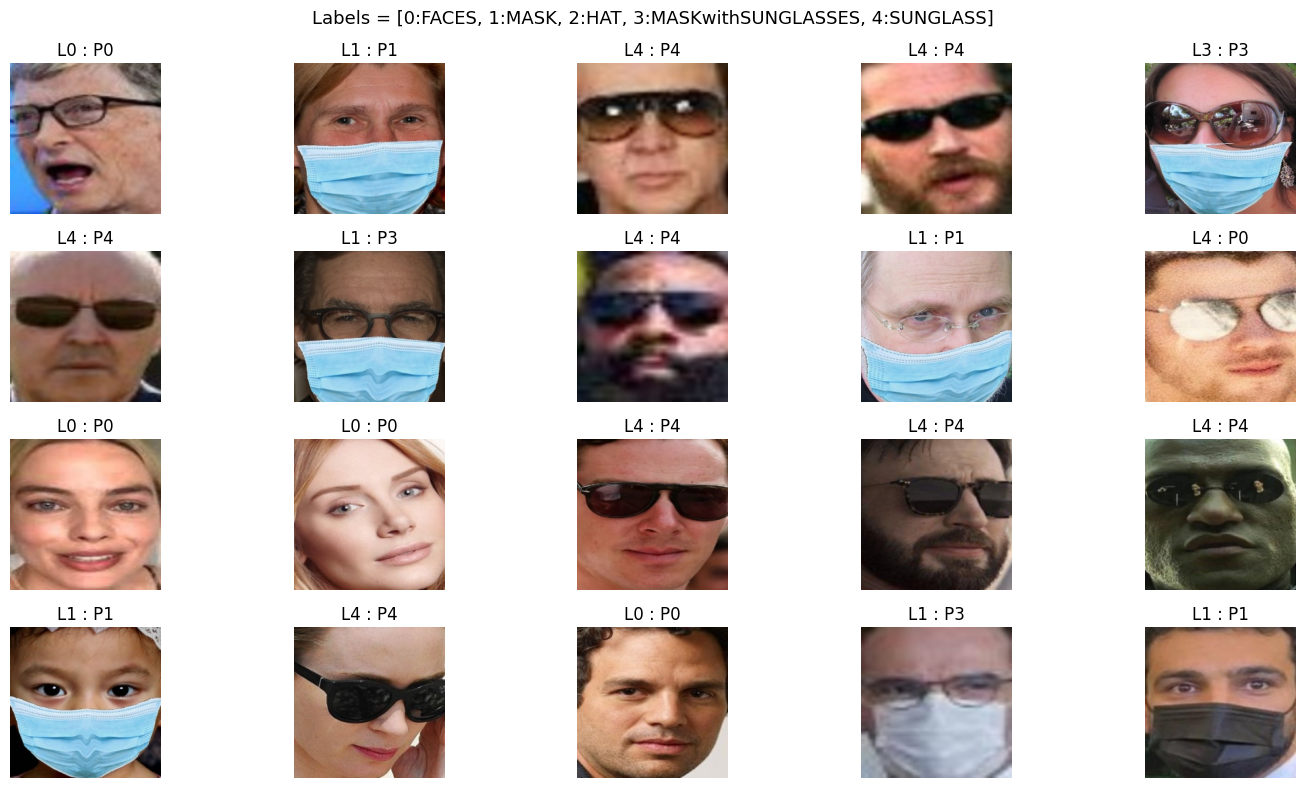

In [22]:
quantized_model('/kaggle/working/saved_models/resnet18/resnet18_train.pth', "resnet18", "TEST", stest_loader)

In [ ]:
# checkpoint = {
#            "state_dict": model.state_dict(),
#            "optimizer": optimizer.state_dict(),
#        }
# print('saving model checkpoint')
# torch.save(checkpoint, 'resnet18_faceclassify.pth.tar')

In [ ]:
# model_scripted = torch.jit.script(model)
# model_scripted.save('model_scripted.pt')

In [23]:
!zip -r resnet18_scratch_allresults.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/saved_models/ (stored 0%)
  adding: kaggle/working/saved_models/resnet18/ (stored 0%)
  adding: kaggle/working/saved_models/resnet18/resnet18_train.pth (deflated 8%)
  adding: kaggle/working/saved_models/resnet18/resnet18_TEST_FXGquant_None.pth (deflated 6%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/classify_results/ (stored 0%)
  adding: kaggle/working/classify_results/fid672.png (deflated 0%)
  adding: kaggle/working/classify_results/fid2120.png (deflated 0%)
  adding: kaggle/working/classify_results/fid361.png (deflated 0%)
  adding: kaggle/working/classify_results/fid19.png (deflated 0%)
  adding: kaggle/working/classify_results/fid1772.png (deflated 0%)
  adding: kaggle/working/classify_results/fid2249.png (deflated 0%)
  adding: kaggle/working/classify_results/fid1204.png (deflated 0%)
  adding: kaggle/working/classify_results/fid61.png (deflated 0%)
  adding: kaggle/working/cla